In [3]:
from __future__ import print_function
import numpy as np
import pandas as pd
import scipy
import sys
import os
from time import time
np.random.seed(1234567)

sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility
from datainterface import patient as Pat

# dimensionality reductions
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.metrics import precision_score, \
    recall_score, classification_report, \
    f1_score

from sklearn.cluster import KMeans
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


# define the data handler 
sys.path.append('../')
import processing.util as util

from sklearn.metrics import r2_score
from scipy.stats import spearmanr, pearsonr

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
datadir = '/Volumes/ADAM LI/pydata/traindata/fft/'

datafiles = []
for root, dirs, files in os.walk(datadir):
    for file in files:
        datafiles.append(os.path.join(root, file))
        
print(len(datafiles))

datahandler = util.DataHandler()

numcomp = 50
# PCA
sklearn_pca = PCA(n_components=numcomp)

print(os.getcwd())

233
/Users/adam2392/Documents/dnn-unsupervised/dnn/baseline analysis


# 1 Load Data and Concatenate 

Assumes, we can't make use of the time dimension. We apply PCA on the frequency feature space, expecting n_components to capture sufficient variability in the data to match the variability that will be seen by the deep neural networks.

- Load data
- PCA (n_components)
- split training/testing data

In [5]:
# keep track of the explained variance 

# load datafiles into features
for idx, datafile in enumerate(datafiles):
    data = np.load(datafile)
    power = data['power']
    seizonsets = data['seizonsets']
    seizoffsets = data['seizoffsets']
    timepoints = data['timepoints']
    
    if idx == 0:
        features = sklearn_pca.fit_transform(power.reshape(-1, power.shape[-1]).T)
        exp_var = sklearn_pca.explained_variance_ratio_[:, np.newaxis]
        Xdata = features
        ydata = datahandler.computelabels(seizonsets,seizoffsets, timepoints)
    else:
        try:
            features = sklearn_pca.fit_transform(power.reshape(-1, power.shape[-1]).T)
            ylabels = datahandler.computelabels(seizonsets,seizoffsets, timepoints)
            exp_var = np.concatenate((exp_var, sklearn_pca.explained_variance_ratio_[:, np.newaxis]), axis=1)

            if len(seizonsets) > 0 and seizonsets[0] != np.nan:
                Xdata = np.concatenate((Xdata, features), axis=0)
                ydata = np.concatenate((ydata,ylabels), axis=0)
            else:
                print(datafile)
        except IndexError:
            print(datafile)
            
print(exp_var.shape)
print(Xdata.shape)
print(ydata.shape)

(50, 233)
(63175, 50)
(63175, 1)


0.9902093902033177


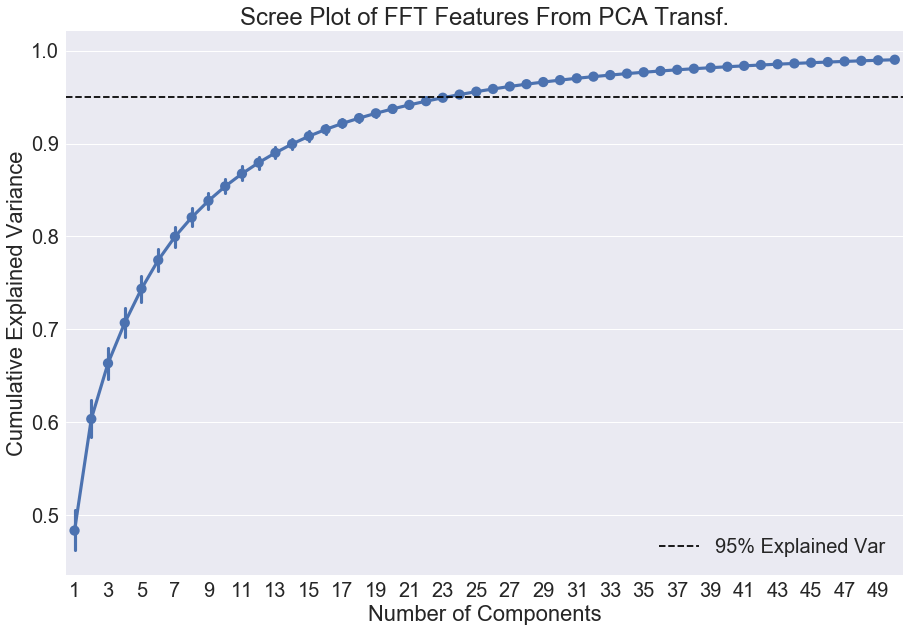

In [6]:
# plot explained var ratio
cumsum = np.cumsum(exp_var, axis=0)
# cumsum_df = pd.DataFrame(index=)
sns.set(font_scale=2)
fig = plt.figure(figsize=(15,10))
sns.pointplot(data=cumsum.T, ci=95)
ax = plt.gca()
ax.set_xticks(np.arange(0,50,2))
ax.set_xticklabels(np.arange(1,51,2))
ax.set_ylabel("Cumulative Explained Variance")
ax.set_xlabel("Number of Components")
ax.set_title("Scree Plot of FFT Features From PCA Transf.")
b = plt.axhline(0.95, color='black', linestyle='--', label='95% Explained Var')
ax.legend(handles=[b], loc=4)

print(np.mean(cumsum[-1,:]))

# 2 Split Into Training and Testing Data

In [7]:
randstate = 42 # for reproducability
X_train, X_test, y_train, y_test = train_test_split(Xdata, ydata, test_size=0.33, random_state=randstate)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(42327, 50)
(20848, 50)
(42327, 1)
(20848, 1)


Baseline training prediction of all seizure:  0.6134618564982163
Baseline testing prediction of all seizure:  0.6031273983115887


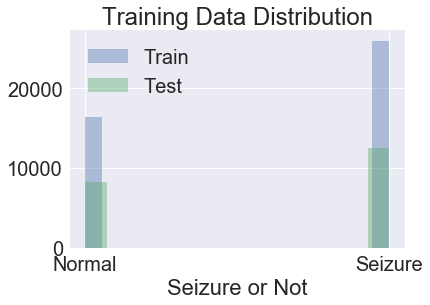

In [37]:
plt.figure()
sns.distplot(y_train, kde=False, axlabel='Seizure or Not', label='Train')
sns.distplot(y_test, kde=False, label='Test')
ax=plt.gca()
ax.set_title('Training Data Distribution')
ax.set_xticks([0,1])
ax.set_xticklabels(['Normal', 'Seizure'])
ax.legend()

print("Baseline training prediction of all seizure: ", np.sum(y_train)/len(y_train))
print("Baseline testing prediction of all seizure: ", np.sum(y_test)/len(y_test))

# 3 Run Models

- Random Forest
- SVM
- Logistic Regression

In [25]:
%%time
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=randstate)
res = rf.fit(X_train, y_train.ravel())
print(res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=42, verbose=0, warm_start=False)
CPU times: user 38.4 s, sys: 295 ms, total: 38.7 s
Wall time: 39 s


Out-of-bag score estimate: 0.656
Mean accuracy score: 0.663
F1 score: 0.7390142517814727
Recall: 0.7917925878797518
Precision: 0.6928322894919973

 clasification report:
              precision    recall  f1-score   support

        0.0       0.60      0.47      0.52      8274
        1.0       0.69      0.79      0.74     12574

avg / total       0.65      0.66      0.65     20848


 confusion matrix:
 [[3860 4414]
 [2618 9956]]


Text(0.5,6,'Predicted Label')

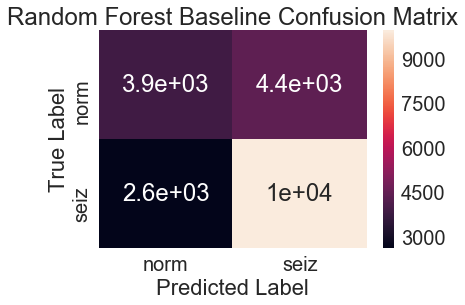

In [26]:
predicted = rf.predict(X_test)
accuracy = accuracy_score(y_test, predicted)

print('Out-of-bag score estimate: %.3f' % rf.oob_score_)
print('Mean accuracy score: %.3f' % accuracy)
print('F1 score:', f1_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('\n clasification report:\n', classification_report(y_test,predicted))
print('\n confusion matrix:\n',confusion_matrix(y_test, predicted))

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=['norm','seiz'], index=['norm','seiz'])
sns.heatmap(cm, annot=True)
ax = plt.gca()
ax.set_title('Random Forest Baseline Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

In [22]:
%%time
logistic = linear_model.LogisticRegression()
scaler = StandardScaler()
# set pipeline to run things using sklearn
pipe = Pipeline(steps=[('scaler', scaler), ('logistic', logistic)])

# Prediction
Cs = np.logspace(-4, 4, 3)
penalty = ['l1', 'l2']
max_iter = [100, 1000, 2000]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(logistic__penalty=penalty,
                              logistic__C=Cs,
                              logistic__max_iter=max_iter
                             ))
result = estimator.fit(X_train, y_train.ravel())
print(result)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logistic', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'logistic__penalty': ['l1', 'l2'], 'logistic__C': array([1.e-04, 1.e+00, 1.e+04]), 'logistic__max_iter': [100, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
CPU times: user 6.57 s, sys: 1.74 s, total: 8.31 s
Wall time: 8.29 s


Mean accuracy score: 0.663
F1 score: 0.7285443171434596
Recall: 0.8243200254493399
Precision: 0.6527078085642317

 clasification report:
              precision    recall  f1-score   support

       norm       0.56      0.33      0.42      8274
      onset       0.65      0.82      0.73     12574

avg / total       0.61      0.63      0.60     20848


 confusion matrix:
 [[ 2759  5515]
 [ 2209 10365]]


Text(0.5,6,'Predicted Label')

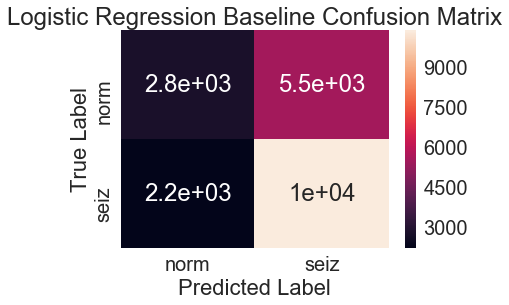

In [24]:
predicted = estimator.predict(X_test)
y_true = y_test

print('Mean accuracy score: %.3f' % accuracy)
print('F1 score:', f1_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('\n clasification report:\n', classification_report(y_test,predicted, target_names=['norm', 'onset']))
print('\n confusion matrix:\n',confusion_matrix(y_test, predicted))

cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=['norm','seiz'], index=['norm','seiz'])
sns.heatmap(cm, annot=True)
ax = plt.gca()
ax.set_title('Logistic Regression Baseline Confusion Matrix')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

In [13]:
%%time 

clf = svm.SVC()
scaler = StandardScaler()
# set pipeline to run things using sklearn
pipe = Pipeline(steps=[('scaler', scaler), ('svm', clf)])

# Prediction
Cs = [1]
kernel=['linear']
# shrinking = [1, 0]
# max_iter = [100, 1000, 2000]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(
                              svm__C=Cs,
                              svm__kernel=kernel,
#                               svm__shrinking=shrinking
                             ))
result = estimator.fit(X_train, y_train.ravel())
print(result)

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'svm__C': [1], 'svm__kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)
CPU times: user 42min 11s, sys: 12.8 s, total: 42min 24s
Wall time: 42min 37s


In [15]:
predicted = estimator.predict(X_test)
y_true = y_test

print('Mean accuracy score: %.3f' % accuracy)
print('F1 score:', f1_score(y_test, predicted))
print('Recall:', recall_score(y_test, predicted))
print('Precision:', precision_score(y_test, predicted))
print('\n clasification report:\n', classification_report(y_test,predicted, target_names=['norm', 'onset']))
print('\n confusion matrix:\n',confusion_matrix(y_test, predicted))

Out-of-bag score estimate: 0.656
Mean accuracy score: 0.663
F1 score: 0.7524385135539465
Recall: 1.0
Precision: 0.6031273983115887

 clasification report:
              precision    recall  f1-score   support

       norm       0.00      0.00      0.00      8274
      onset       0.60      1.00      0.75     12574

avg / total       0.36      0.60      0.45     20848


 confusion matrix:
 [[    0  8274]
 [    0 12574]]


/Users/adam2392/Documents/dnn-unsupervised/.venv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


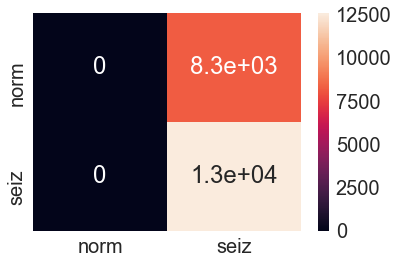

In [16]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=['norm','seiz'], index=['norm','seiz'])
sns.heatmap(cm, annot=True)


# predicted_train = rf.predict(X_train)
# predicted_test = rf.predict(X_test)
# test_score = r2_score(y_test, predicted_test)
# spearman = spearmanr(y_test, predicted_test)
# pearson = pearsonr(y_test, predicted_test)
# print('Out-of-bag R-2 score estimate: %.3f ' % rf.oob_score_)
# print('Test data R-2 score: %.3f ' % test_score)
# print('Test data Spearman correlation: %.3f ' % spearman[0])
# print('Test data Pearson correlation: %.3f ' % pearson[0])

In [ ]:
# run KMeans many times
kclust = 2
numsamples = X.shape[0]

kmeans = KMeans(n_clusters=kclust).fit(X)

def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
#     print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
    print('%-9s\t%.2fs\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=numsamples),
             metrics.accuracy_score(labels, estimator.labels_)
            ))

print(82 * '_')
# thomo\tcompl\tv-meas\tARI\tAMI\
print('init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette\taccuracy')

bench_k_means(KMeans(init='k-means++', n_clusters=kclust, n_init=10),
              name="k-means++", data=X)

bench_k_means(KMeans(init='random', n_clusters=kclust, n_init=10),
              name="random", data=X)

In [ ]:
cm = pd.DataFrame(confusion_matrix(y_test, predicted), columns=['norm','onset'], index=['norm','onset'])
sns.heatmap(cm, annot=True)


predicted_train = rf.predict(X_train)
predicted_test = rf.predict(X_test)
test_score = r2_score(y_test, predicted_test)
spearman = spearmanr(y_test, predicted_test)
pearson = pearsonr(y_test, predicted_test)
print('Out-of-bag R-2 score estimate: %.3f ' % rf.oob_score_)
print('Test data R-2 score: %.3f ' % test_score)
print('Test data Spearman correlation: %.3f ' % spearman[0])
print('Test data Pearson correlation: %.3f ' % pearson[0])